In [23]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

In [24]:
df = pd.read_csv("C:\\AIMANA\\AcoTubos\\data\\poc_acotubo_17_06_2025.csv")
df = df.dropna(subset= ['Desconto', 'Margem'])
df

,Year,day_of_year,FaixaPeso,ProdutoFamilia,ProdutoDescricao,ProdutoGrupoSOP,Canal,EmpresaNome,ClienteCNPJCPF,totalSold,TotalQuoted,nuPrecoGerenciaTotal,Desconto,ConversionRate_%,Margem
0,2022,3,1.001 A 2.000 KG,AÇOS ESPECIAIS,"ACO TREF RED 11SMN37 25,40 MM CNA N",04-AÇO RESSULFURADO,VAREJO,TUBOS E AÇOS PR,06271863000180,0.18,0.18,2561.40,0.00,100.00,20.03
1,2022,3,1.001 A 2.000 KG,AÇOS LONGOS,"ACO LAM RED SAE 1045 FX 1.3/4"" CNA N",05-AÇO FAIXA,VAREJO,TUBOS E AÇOS MTZ,54183819000160,1.52,1.52,20282.78,-6.50,100.00,32.44
2,2022,3,1.001 A 2.000 KG,AÇOS LONGOS,"ACO TREF RED SAE 1045 2.1/2"" CNA N",06-AÇO TREFILADO,VAREJO,TUBOS E AÇOS MG,17732545000276,0.75,0.75,11587.50,0.00,100.00,24.95
3,2022,3,1.001 A 2.000 KG,AÇOS LONGOS,ACO TREF RED SAE 1045 20 MM CNA N,06-AÇO TREFILADO,VAREJO,TUBOS E AÇOS PR,06271863000180,1.58,1.58,20914.73,0.00,100.00,24.86
4,2022,3,1.001 A 2.000 KG,AÇOS LONGOS,"AÇO LAM RED SAE 1045 FX 1.1/2"" CNA N",05-AÇO FAIXA,VAREJO,TUBOS E AÇOS MG,17732545000276,0.43,0.43,5603.73,0.00,100.00,24.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83351,2024,358,1.001 A 2.000 KG,AÇOS LONGOS,"ACO LAM RED SAE 1045 FX 2"" CNA N",05-AÇO FAIXA,VAREJO,TUBOS E AÇOS MG,12606567000195,0.01,0.01,96.80,1.85,100.00,19.59
83352,2024,358,1.001 A 2.000 KG,AÇOS LONGOS,"AÇO LAM RED SAE 1045 FX 2.1/4"" CNA N",05-AÇO FAIXA,VAREJO,TUBOS E AÇOS MG,12606567000195,0.01,0.01,82.26,-1.02,100.00,23.43
83353,2024,358,1.001 A 2.000 KG,AÇOS LONGOS,"AÇO LAM RED SAE 1045 FX 3"" CNA N",05-AÇO FAIXA,VAREJO,TUBOS E AÇOS MG,12606567000195,0.01,0.01,146.16,-1.46,100.00,24.73
83354,2024,358,1.001 A 2.000 KG,AÇOS LONGOS,"AÇO LAM RED SAE 1045 FX 3.1/2"" CNA N",05-AÇO FAIXA,VAREJO,TUBOS E AÇOS MG,12606567000195,0.31,0.31,3009.60,0.02,100.00,23.29


In [25]:
#removendo aspas duplas e substituindo por aspas simples para tentar corrigir erro da API (json input no formato incorreto)
df['ProdutoDescricao']= df['ProdutoDescricao'].str.replace('"', "'", regex= False)

In [26]:
def identify_outliers_iqr(df, column):
    """
    Identifica outliers usando o método IQR (Intervalo Interquartil).
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers



idx_outliers_conversionrate = identify_outliers_iqr(df, 'ConversionRate_%').index.tolist()
idx_outliers_margem = identify_outliers_iqr(df, 'Margem').index.tolist()

idx_unique_outliers = idx_outliers_conversionrate + idx_outliers_margem
idx_unique_outliers = list(set(idx_unique_outliers)) #unique indexes

df_without_outliers= df.drop(idx_unique_outliers, axis= 0)

print(f'original dataframe shape: {df.shape}')
print(f'Dataframe without outliers shape: {df_without_outliers.shape}')

original dataframe shape: (83263, 15)
Dataframe without outliers shape: (61565, 15)


In [27]:
df.isnull().sum()

Year                    0
day_of_year             0
FaixaPeso               0
ProdutoFamilia          0
ProdutoDescricao        0
ProdutoGrupoSOP         0
Canal                   0
EmpresaNome             0
ClienteCNPJCPF          0
totalSold               0
TotalQuoted             0
nuPrecoGerenciaTotal    0
Desconto                0
ConversionRate_%        0
Margem                  0
dtype: int64

In [28]:
X = df.drop(["ConversionRate_%", "Margem",], axis=1)

y = df["ConversionRate_%"]



# X = df_without_outliers.drop(["ConversionRate_%", "Margem"], axis=1)

# y = df_without_outliers["ConversionRate_%"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
categorical_cols_ohe = X_train.drop(['ProdutoDescricao', "EmpresaNome", "ClienteCNPJCPF"], axis= 1).select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols_le= ['ProdutoDescricao', "EmpresaNome", "ClienteCNPJCPF"]

In [31]:
num_preprocessor = Pipeline([
    ('trasnformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])


cat_preprocessor_ohe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown= 'ignore', sparse_output= False)) #, max_categories= 50
])

cat_preprocessor_le = Pipeline([
    ('encoder_le', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


#preprocessor
preprocessor = ColumnTransformer([
    ('num', num_preprocessor, numeric_cols),
    ('cat_ohe', cat_preprocessor_ohe, categorical_cols_ohe),
    ('cat_le', cat_preprocessor_le, categorical_cols_le)
])

### ConversionRate 

<Axes: ylabel='Frequency'>

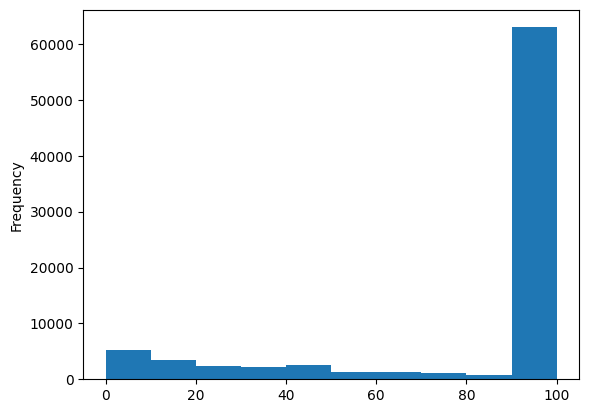

In [32]:
df['ConversionRate_%'].plot(kind= 'hist')

# df_without_outliers['ConversionRate_%'].plot(kind= 'hist')

In [33]:
models = [
    HuberRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    DecisionTreeRegressor()
]

Model: HuberRegressor

R2: 0.62
MAE: 15.18


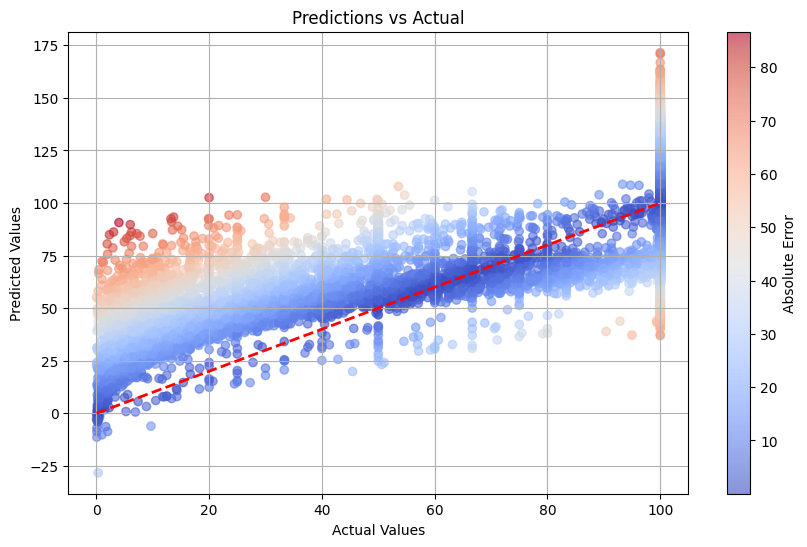


Model: RandomForestRegressor

R2: 1.0
MAE: 0.21


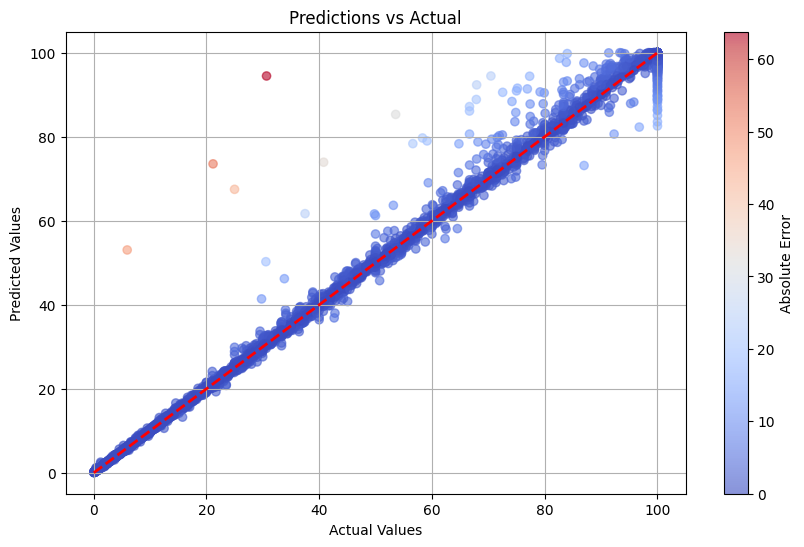


Model: XGBRegressor

R2: 1.0
MAE: 0.39


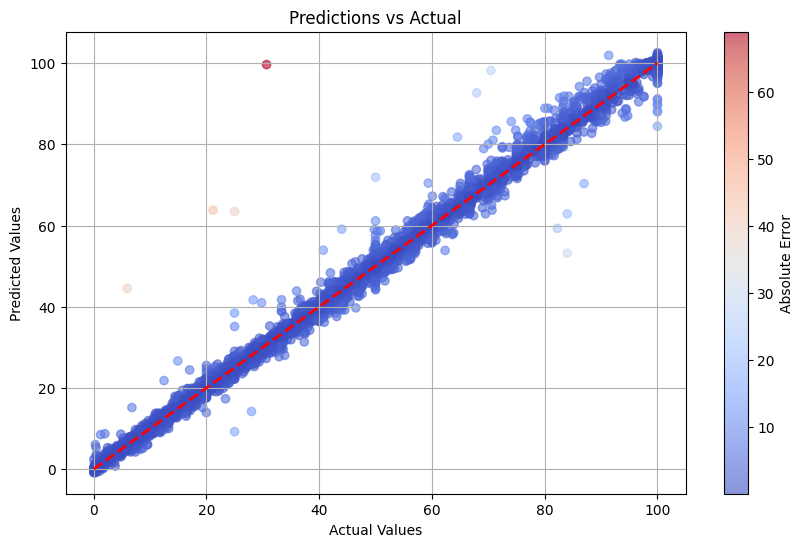


Model: DecisionTreeRegressor

R2: 1.0
MAE: 0.33


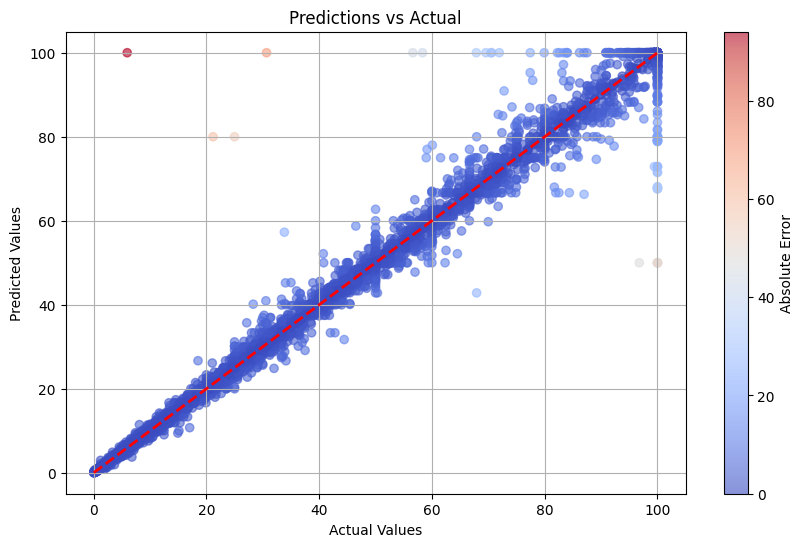

In [34]:
for model in models:

    #pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])


    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)   

    print(f"Model: {model.__class__.__name__}\n")
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {round(r2, 2)}")
    MAE = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {round(MAE, 2)}")

    #plotting predictions vs actual values
    errors = np.abs(y_test - y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual')
    plt.colorbar(label='Absolute Error')
    plt.grid(True)
    plt.show()
    print('=' * 120, '\n')

    if model.__class__.__name__ == 'RandomForestRegressor':
        joblib.dump(pipeline, '2_poc_conversion_model_rf_df_16062025.joblib')

### Margem

<Axes: ylabel='Frequency'>

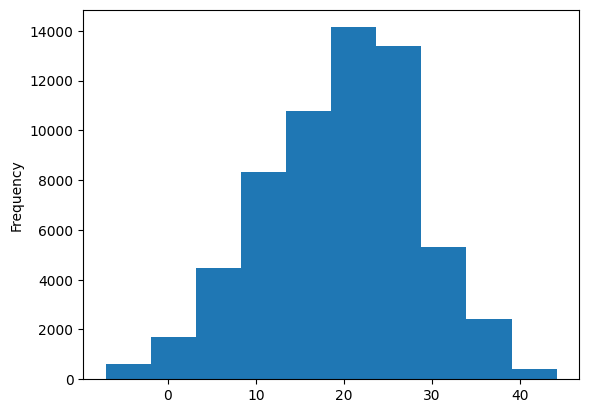

In [35]:
# df['Margem'].plot(kind= 'hist')

df_without_outliers['Margem'].plot(kind= 'hist')

In [36]:
# X = df.drop(['Margem', 'ConversionRate', 'EmpresaNome', 'ClienteCNPJCPF', 'ProdutoDescricao'], axis=1) 
# y = df["Margem"]


X = df_without_outliers.drop(['Margem', 'ConversionRate_%'], axis=1) 
y = df_without_outliers["Margem"]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
categorical_cols_ohe = X_train.drop(['ProdutoDescricao', "EmpresaNome", "ClienteCNPJCPF"], axis= 1).select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols_le= ['EmpresaNome', 'ClienteCNPJCPF', 'ProdutoDescricao']

In [38]:
num_preprocessor = Pipeline([
    ('trasnformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])


cat_preprocessor_ohe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown= 'ignore', sparse_output= False)) #, max_categories= 50
])

cat_preprocessor_le = Pipeline([
    ('encoder_le', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


#preprocessor
preprocessor = ColumnTransformer([
    ('num', num_preprocessor, numeric_cols),
    ('cat_ohe', cat_preprocessor_ohe, categorical_cols_ohe),
    ('cat_le', cat_preprocessor_le, categorical_cols_le)
])

Model: HuberRegressor

R2: 0.21
MAE: 5.43


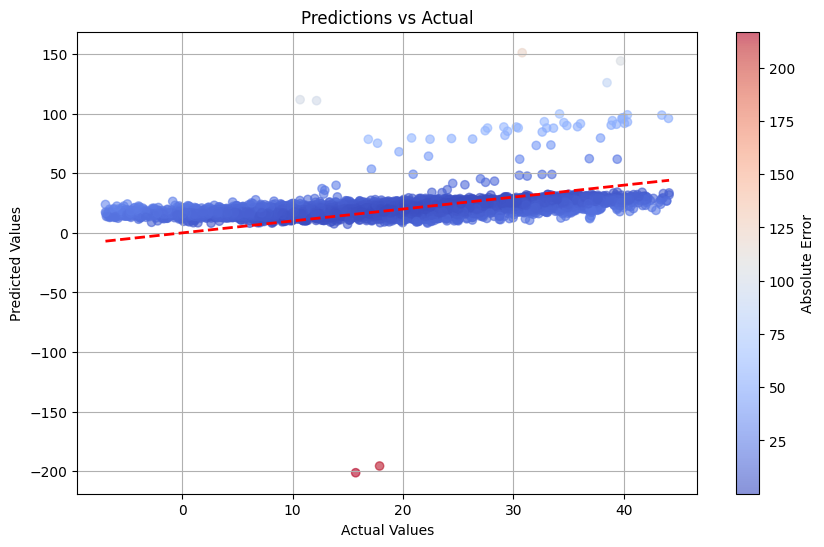


Model: RandomForestRegressor

R2: 0.95
MAE: 0.83


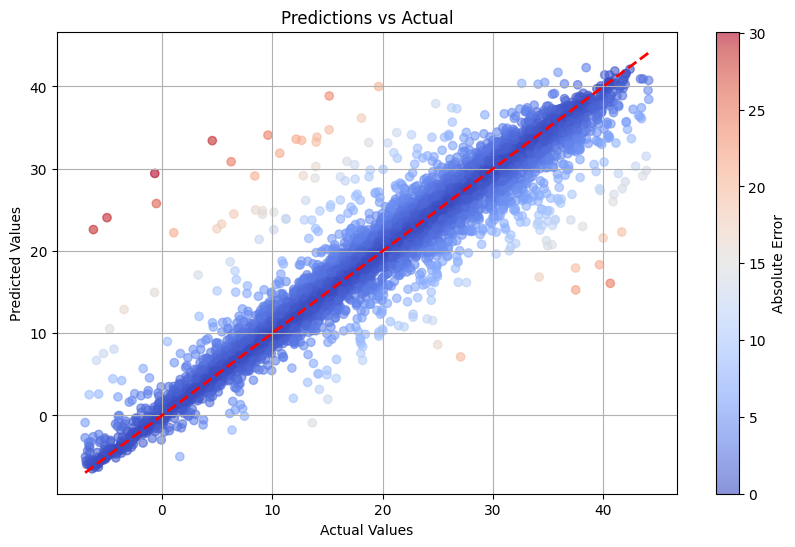


Model: XGBRegressor

R2: 0.96
MAE: 0.82


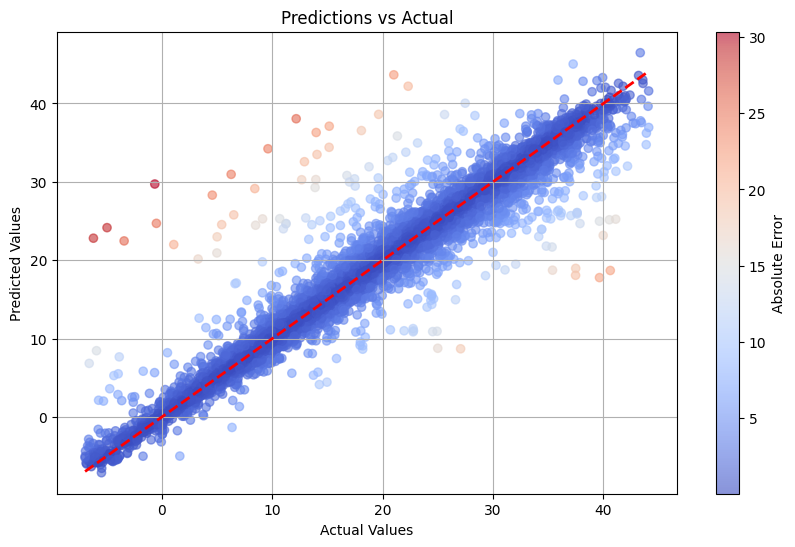


Model: DecisionTreeRegressor

R2: 0.91
MAE: 1.07


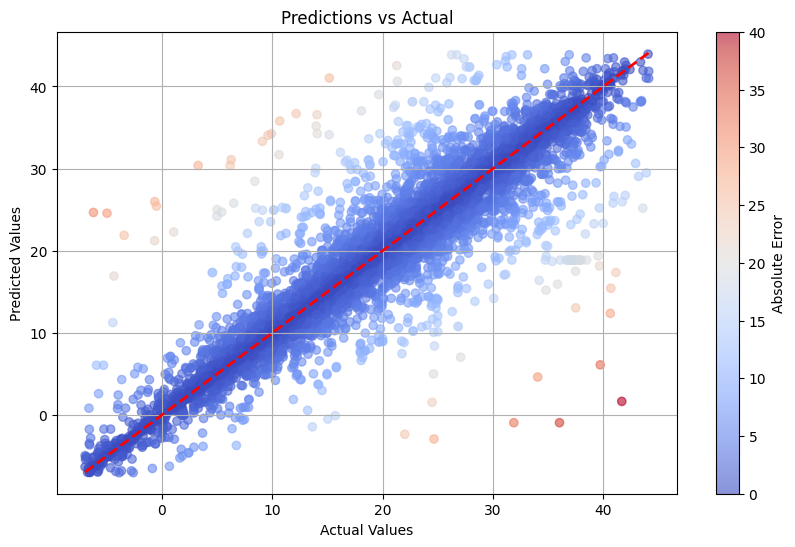

In [39]:
models = [ 
    HuberRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    DecisionTreeRegressor()
]

for model in models:
    #pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    #metrics
    print(f"Model: {model.__class__.__name__}\n")
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {round(r2, 2)}")
    MAE = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {round(MAE, 2)}")

    #plotting predictions vs actual values
    errors = np.abs(y_test - y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual')
    plt.colorbar(label='Absolute Error')
    plt.grid(True)
    plt.show()
    print('=' * 120, '\n')

    #saving XGBRegressor (best model)
    if model.__class__.__name__ == 'XGBRegressor':
        joblib.dump(pipeline, '2_poc_margem_model_xgb_df_16062025.joblib')